In [1]:
import tensorflow as tf


gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D, Conv2DTranspose
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

In [3]:
ds = tfds.load('fashion_mnist', split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteKKJHSD/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteKKJHSD/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


Visualize the Dataset

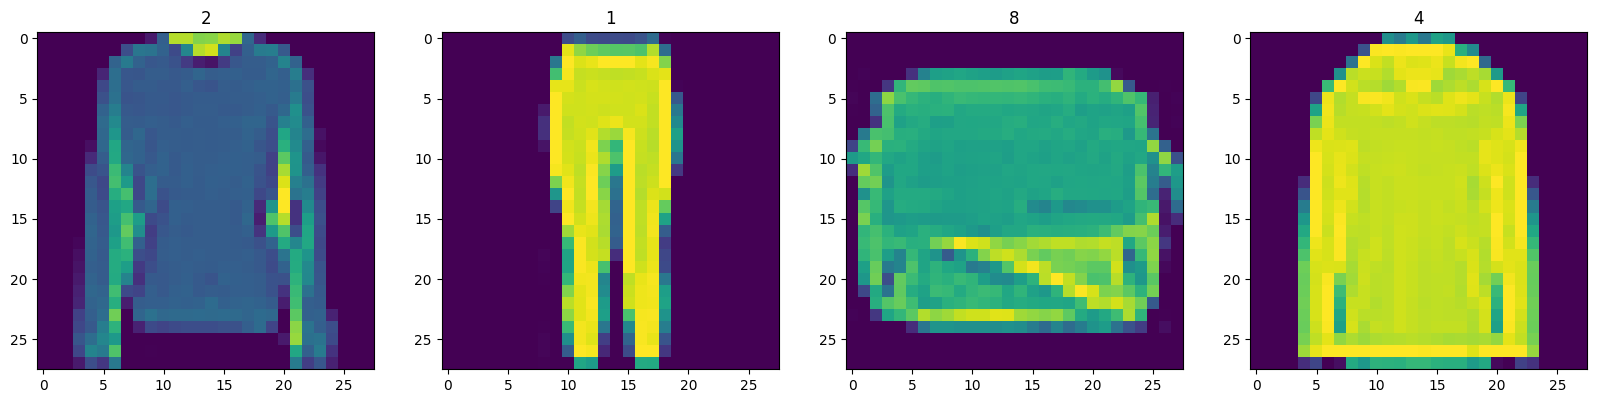

In [4]:
iterator = ds.as_numpy_iterator()

fig, ax = plt.subplots(ncols = 4, figsize=(20,20))
for idx in range(4):
    sample = iterator.next()
    ax[idx].imshow(sample['image'])
    ax[idx].title.set_text(sample['label'])

In [5]:
def scale_image(data):
    image = data['image']
    return image / 255

### **Building the Neural Network**

Building the Generator

In [28]:
def build_generator():
    model = Sequential()

    model.add(Dense(7*7*128, input_dim=128)) 
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128))) 
    
    # upsample to 14x14
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #14x14x128
    model.add(LeakyReLU(alpha=0.2))
    
    # upsample to 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #28x28x128
    model.add(LeakyReLU(alpha=0.2))
    
    # generate
    model.add(Conv2D(1, (8,8), activation='tanh', padding='same')) #28x28x1

    return model

Building the Discriminator



In [7]:
def build_discriminator():
    model = Sequential()

    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=(28,28,1)))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same')) 
    model.add(LeakyReLU(alpha=0.2))

    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    opt = Adam(lr=0.0002)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    return model

In [8]:
def build_gan(generator, discriminator):
    #Discriminator is trained separately
    discriminator.trainable = False

    model = Sequential()
    model.add(generator)
    model.add(discriminator)

    opt = Adam(learning_rate=0.0002)
    model.compile(loss='binary_crossentropy', optimizer = opt)

    return model

In [9]:
def generate_latent_input(latent_dim, sample_size):
    X = tf.random.normal((sample_size, latent_dim, 1))
    return X

In [10]:
def generate_real_images(dataset, sample_size):
    ix = np.random.randint(0, dataset.shape[0], sample_size)
    X = dataset[ix]
    y = np.ones((sample_size,1))
    return X, y

In [11]:
def generate_fake_images(generator, latent_dim, sample_size):
    X = generate_latent_input(latent_dim, sample_size)
    X = generator.predict(X, verbose=0)
    y = np.zeros((sample_size, 1))
    return X, y

In [12]:
def plot_generated_sample(generator, latent_dim):
    X = generate_latent_input(latent_dim, 8)
    images = generator.predict(X, verbose=0)

    fig, ax = plt.subplots(ncols = 8, figsize=(20,20))
    for idx, image in enumerate(images):
        ax[idx].imshow(image)
        ax[idx].title.set_text(idx)

### **Construct Training Loop**

In [13]:
def train_gan(g_model, d_model, gan_model, dataset, latent_dim, epochs=100, batch_size=128):

    for epoch in range(epochs):

        X_real, y_real = generate_real_images(dataset, (batch_size))
        X_fake, y_fake = generate_fake_images(g_model, latent_dim, (batch_size))

        X_train = np.concatenate([X_real, X_fake])
        y_train = np.concatenate([y_real, y_fake])
        d_loss, _ = d_model.train_on_batch(X_train, y_train)

        X_gan = generate_latent_input(latent_dim, batch_size)
        y_gan = np.ones((batch_size,1))

        g_loss = gan_model.train_on_batch(X_gan, y_gan)

        if (epoch+1) % 1000 == 0:
            print('Epoch %d, d=%.3f, g=%.3f' % (epoch+1, d_loss, g_loss))

        if (epoch+1) % 2000 == 0:
            g_model.save('generator_' + str(epoch+1) + '.h5')
            d_model.save('discriminator_' + str(epoch+1) + '.h5')
            gan_model.save('gan_' + str(epoch+1) + '.h5')
            plot_generated_sample(g_model, latent_dim)


## **Training** **GAN**

In [14]:
#Load dataset
ds = tfds.load('fashion_mnist', split='train')

#Scaling the images - preprocessing
ds = ds.map(scale_image)

data_size = tf.data.experimental.cardinality(ds).numpy()

#Shuffle the dataset
ds = ds.shuffle(data_size)

dataset = list(ds.as_numpy_iterator())
dataset = np.array(dataset)

In [15]:
print('Number of Training images: ',dataset.shape)

Number of Training images:  (60000, 28, 28, 1)


In [16]:
generator = build_generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 128)      262272    
 ranspose)                                              

1/1 [==============================] - 11s 11s/step


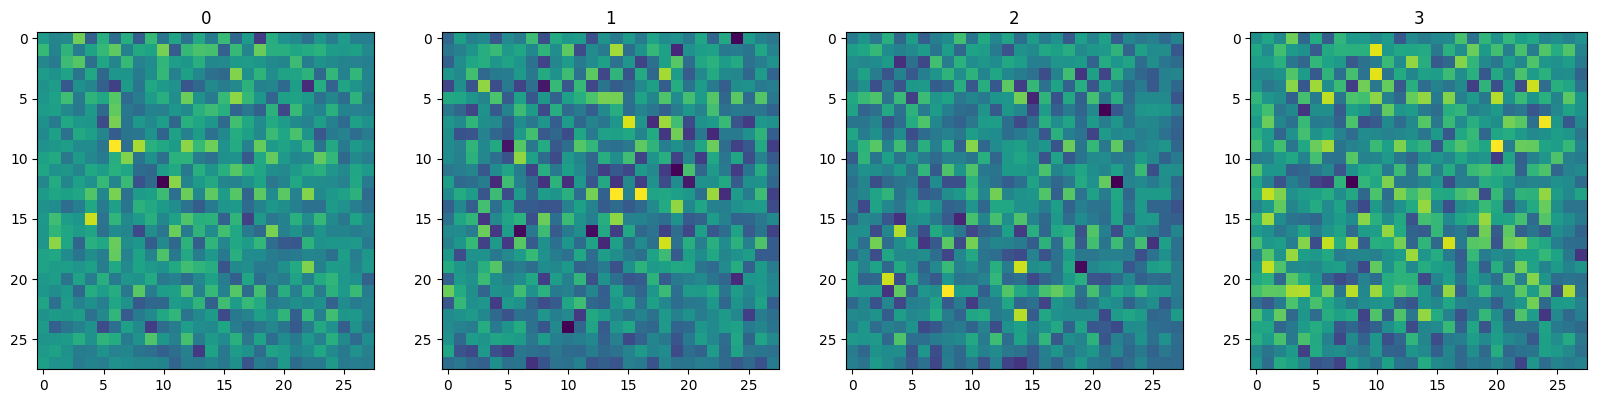

In [17]:
# Generate and plot 4 random images
img = generator.predict(tf.random.normal((4,128,1)))

fig, ax = plt.subplots(ncols = 4, figsize=(20,20))
for idx, image in enumerate(img):
    ax[idx].imshow(image)
    ax[idx].title.set_text(idx)

In [18]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 14, 14, 128)       1280      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 128)         147584    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dropout (Dropout)           (None, 6272)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                

/opt/conda/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [19]:
discriminator.predict(img)

1/1 [==============================] - 0s 140ms/step


array([[0.4999445 ],
       [0.49950364],
       [0.50036454],
       [0.5002635 ]], dtype=float32)

In [20]:
gan = build_gan(generator, discriminator)
gan.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 28, 28, 1)         1341825   
                                                                 
 sequential_2 (Sequential)   (None, 1)                 155137    
                                                                 
Total params: 1,496,962
Trainable params: 1,341,825
Non-trainable params: 155,137
_________________________________________________________________


Epoch 1000, d=0.695, g=0.591
Epoch 3000, d=0.357, g=1.564
Epoch 4000, d=0.312, g=1.785
Epoch 5000, d=0.233, g=2.341
Epoch 6000, d=0.256, g=2.024
Epoch 7000, d=0.169, g=2.577
Epoch 8000, d=0.234, g=2.084
Epoch 9000, d=0.227, g=2.356
Epoch 10000, d=0.274, g=2.143
Epoch 11000, d=0.249, g=2.169
Epoch 12000, d=0.189, g=2.200
Epoch 13000, d=0.186, g=2.203
Epoch 14000, d=0.227, g=2.277
Epoch 15000, d=0.249, g=2.431
Epoch 16000, d=0.262, g=2.562
Epoch 17000, d=0.309, g=2.628
Epoch 18000, d=0.211, g=2.208
Epoch 19000, d=0.235, g=2.743
Epoch 20000, d=0.269, g=2.074


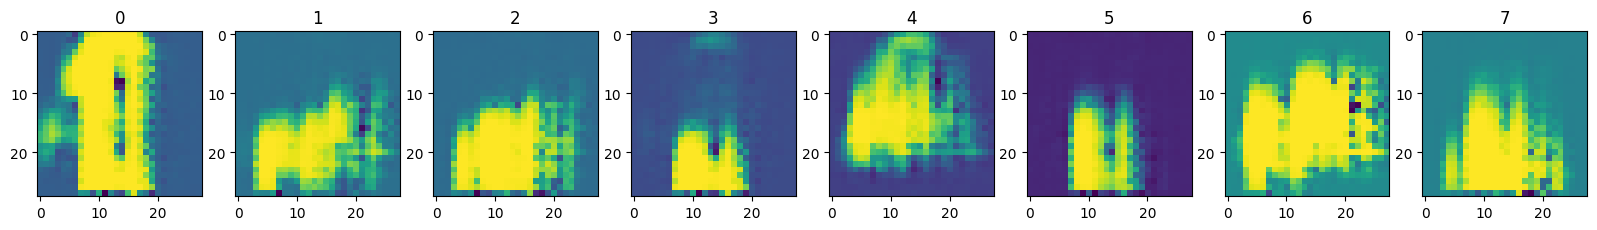

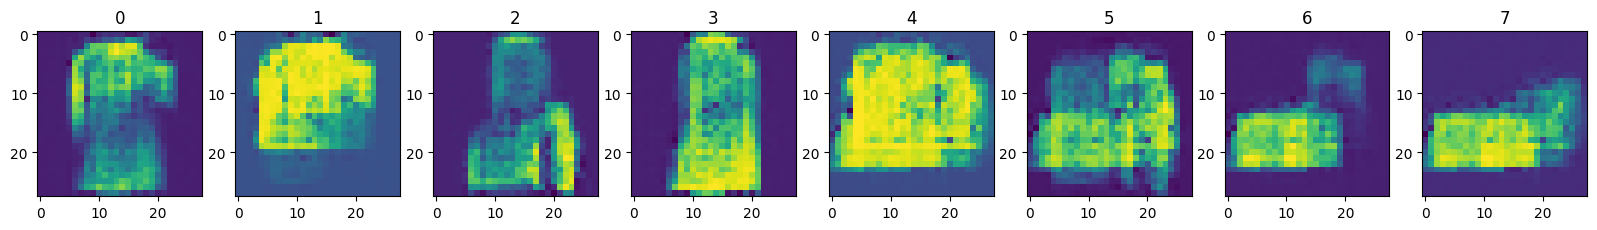

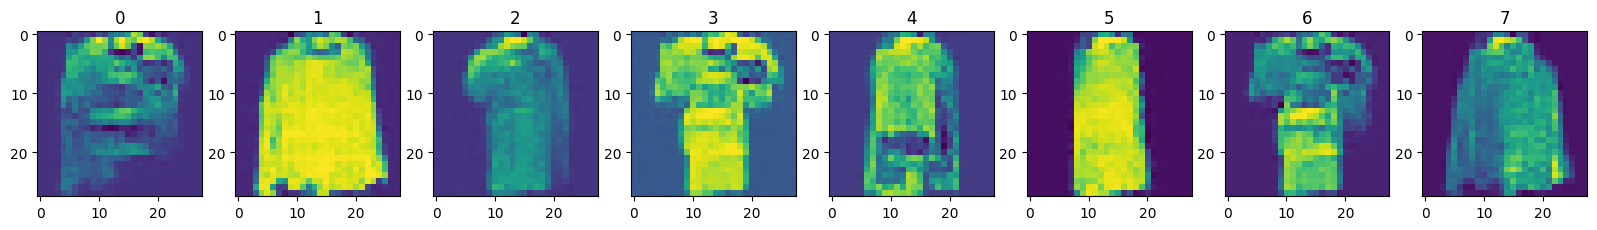

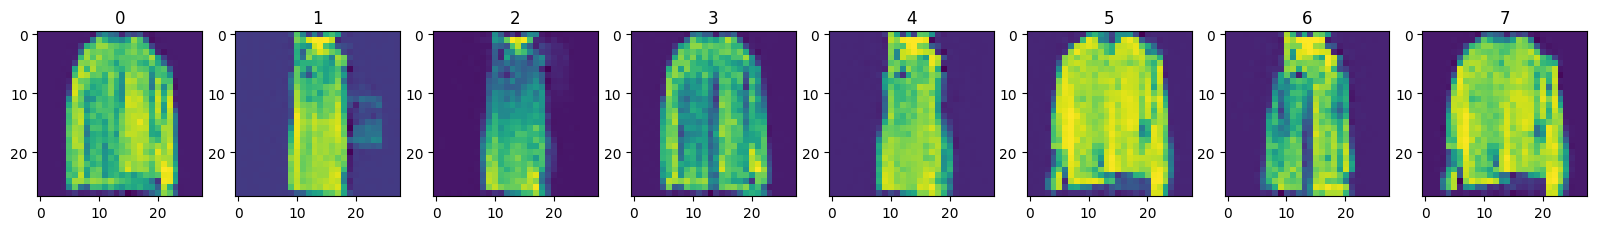

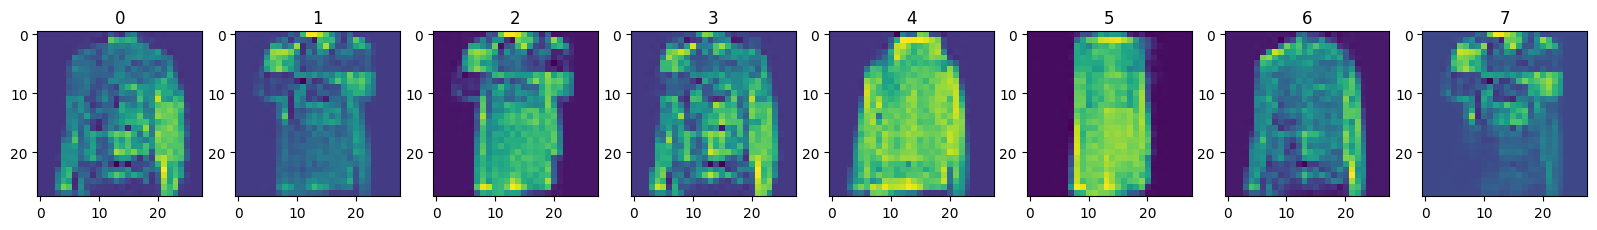

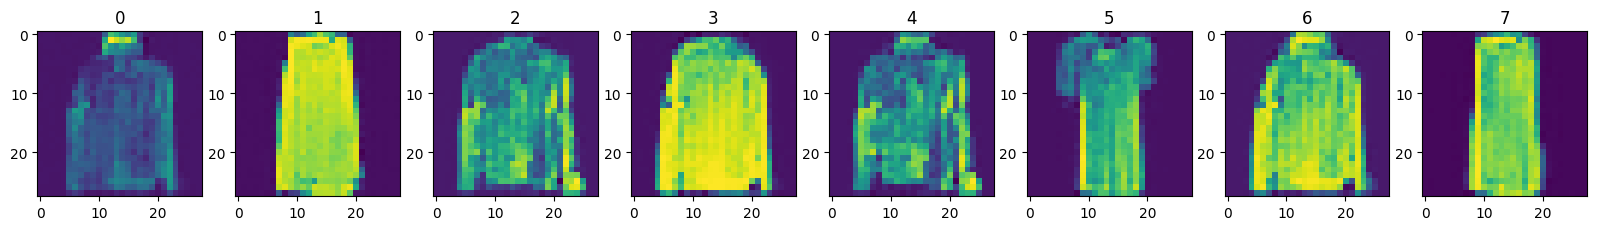

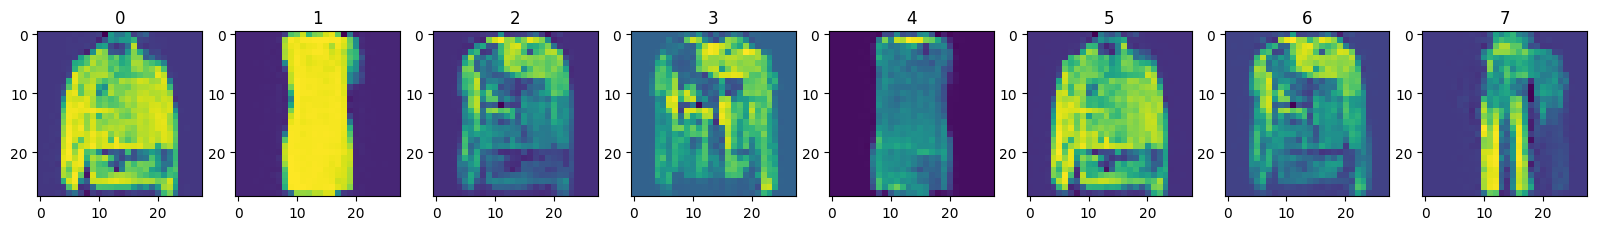

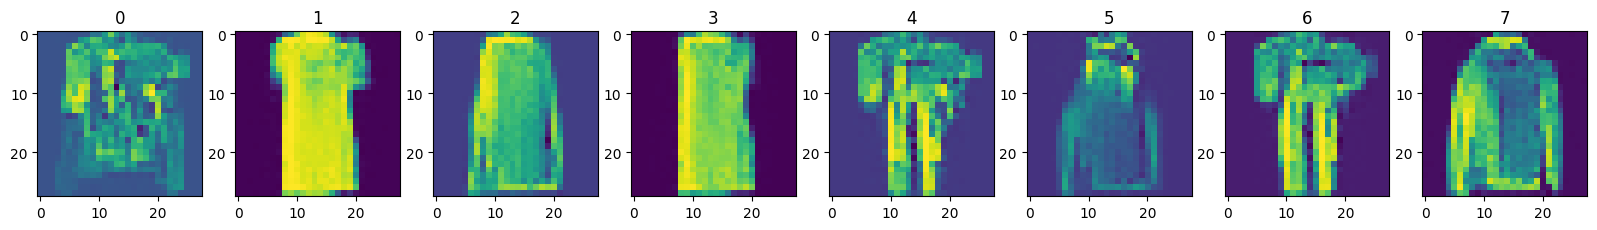

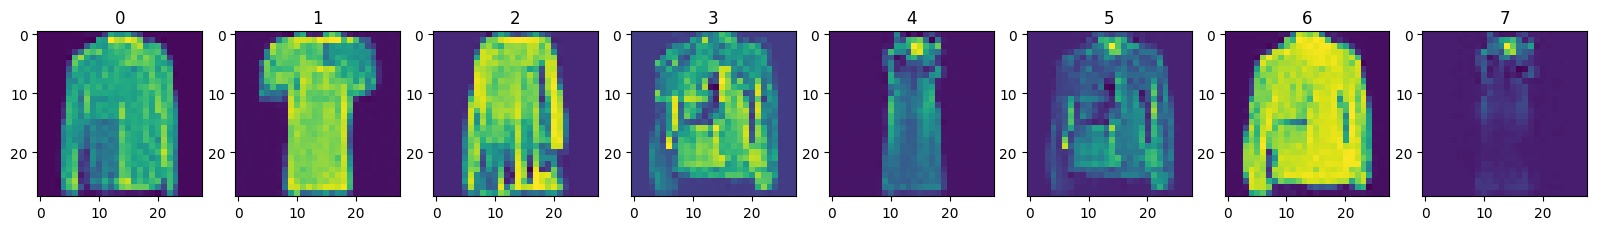

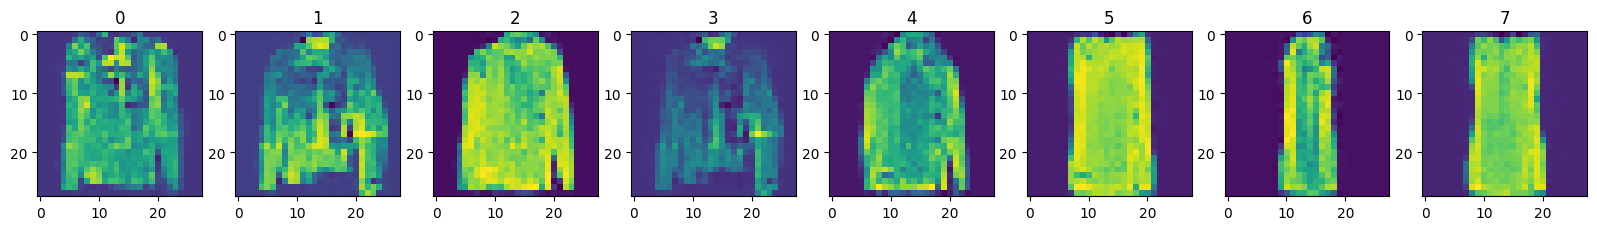

In [23]:
train_gan(generator, discriminator, gan, dataset, 128, 20000, 128)

1/1 [==============================] - 0s 30ms/step


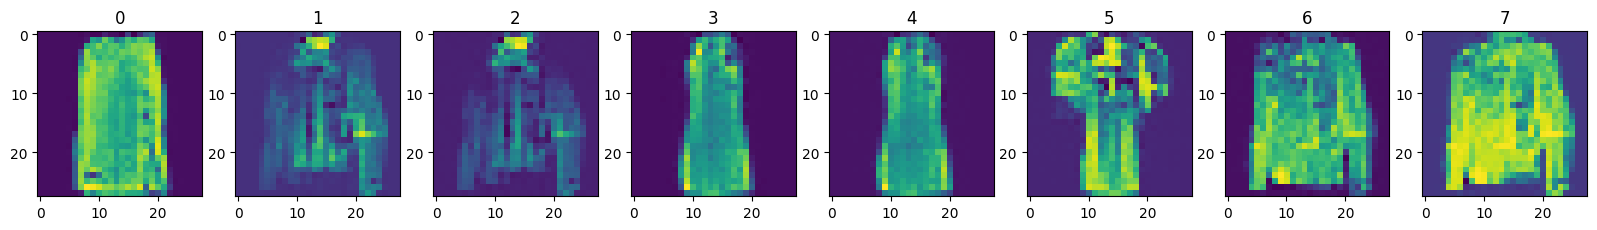

In [24]:
# Generate and plot 4 random images
img = generator.predict(tf.random.normal((8,128,1)))

fig, ax = plt.subplots(ncols = 8, figsize=(20,20))
for idx, image in enumerate(img):
    ax[idx].imshow(image)
    ax[idx].title.set_text(idx)

Load Already trained Model

In [25]:
generator = load_model('generator_20000.h5')

In [26]:
generator

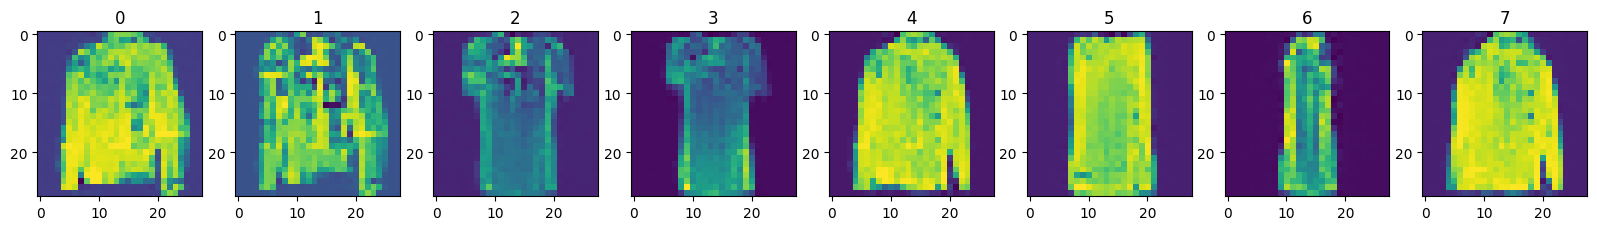

In [27]:
plot_generated_sample(generator, 128)
